In [1]:
import torch
import torch.nn as nn
from torch import optim
import torchvision
from torchvision import datasets, transforms
import typing
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler


from trainer import Trainer, compute_loss_and_accuracy
from task2 import create_plots
from dataloaders import get_data_dir
import utils 




In [2]:
def load_cifar10(batch_size: int, validation_fraction: float = 0.1, resize: int = 224) -> typing.List[torch.utils.data.DataLoader]:
    # Normalization values specific for models trained on ImageNet
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Define transforms for the training data and testing data
    transform_list = [
        transforms.Resize((resize, resize)),  # Resize images
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]
    
    transform = transforms.Compose(transform_list)

    data_train = datasets.CIFAR10('./data',
                                  train=True,
                                  download=True,
                                  transform=transform)

    data_test = datasets.CIFAR10('./data',
                                 train=False,
                                 download=True,
                                 transform=transform)

    # Split the training data into training and validation sets
    indices = list(range(len(data_train)))
    split_idx = int(np.floor(validation_fraction * len(data_train)))

    np.random.shuffle(indices)  # Ensure randomness
    val_indices = indices[:split_idx]
    train_indices = indices[split_idx:]

    # Create data samplers
    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)

    # Create data loaders
    dataloader_train = torch.utils.data.DataLoader(data_train,
                                                   sampler=train_sampler,
                                                   batch_size=batch_size,
                                                   num_workers=2,
                                                   drop_last=True)

    dataloader_val = torch.utils.data.DataLoader(data_train,
                                                 sampler=validation_sampler,
                                                 batch_size=batch_size,
                                                 num_workers=2)

    dataloader_test = torch.utils.data.DataLoader(data_test,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=2)

    return [dataloader_train, dataloader_val, dataloader_test]

In [3]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(512, num_classes)  
        
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        for param in self.model.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.model(x)

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
ResNetModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Batches per seconds: 83.48, Global step:    703, Validation Loss: 0.36, Validation Accuracy: 0.874
Epoch: 0, Batches per seconds: 57.67, Global step:   1406, Validation Loss: 0.29, Validation Accuracy: 0.896
Epoch: 1, Batches per seconds: 52.22, Global step:   2109, Validation Loss: 0.31, Validation Accuracy: 0.894
Epoch: 1, Batches per seconds: 53.76, Global step:   2812, Validation Loss: 0.29, Validation Accuracy: 0.897
Epoch: 2, Batches per seconds: 51.37, Global step:   3515, Validation Loss: 0.31, Validation Accuracy: 0.905
Epoch: 2, Batches per seconds: 52.31, Global step:   4218, Validation Loss: 0.27, Validation Accuracy: 0.910
Epoch: 3, Batches per seconds: 50.98, Global step:   4921, Validation Loss: 0.37, Validation Accuracy: 0.893
Epoch: 3, Batches per seconds: 51.83, Global step:   5624, Validation Loss: 0.31, Validation Accuracy: 0.906
Epoch: 4, Batches per seconds: 52.41, Global step:   6327, Validation Loss: 0.31, Validation Accuracy: 0.909
Epoch: 4, Batches p

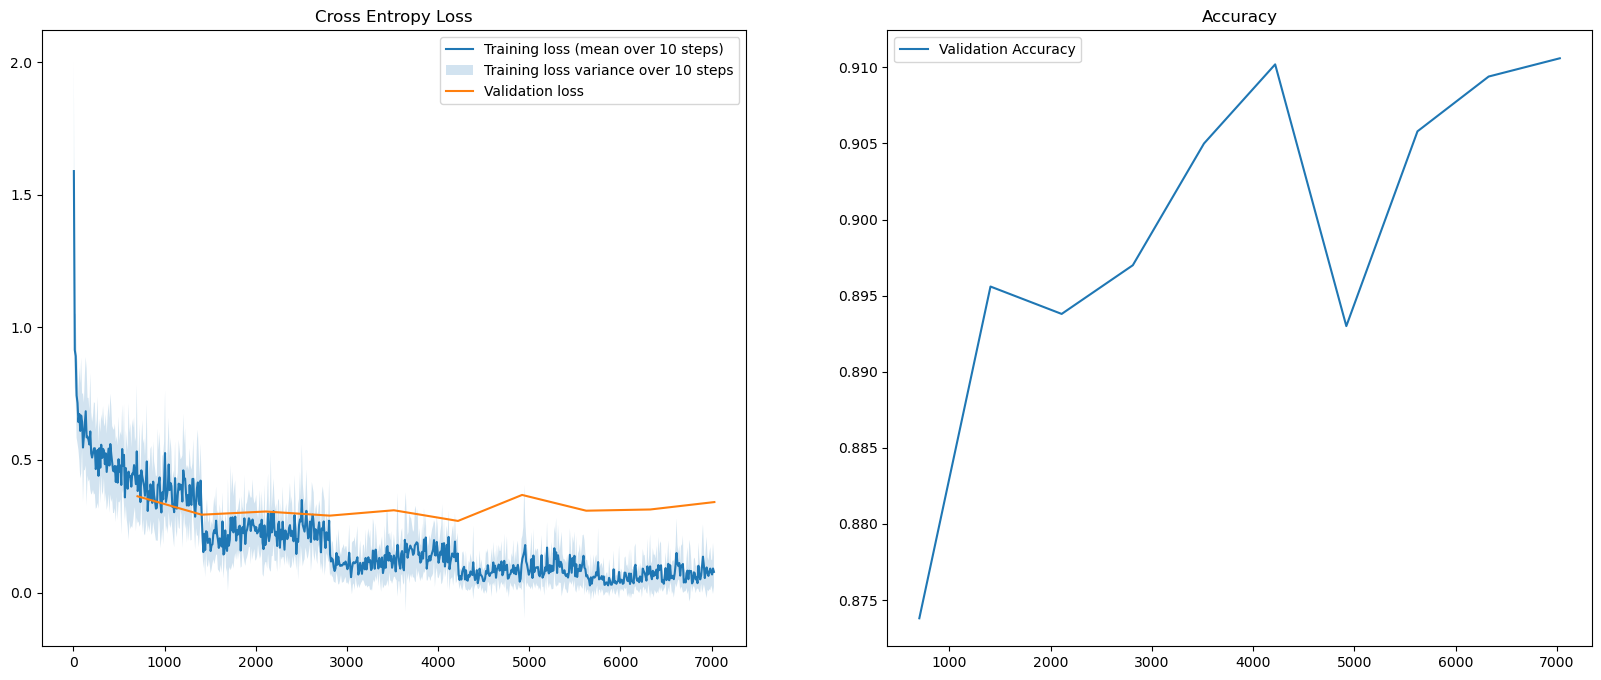

In [4]:
utils.set_seed(0)  
print(f"Using device: {utils.get_device()}")
epochs = 5
batch_size = 32
learning_rate = 5e-4  
early_stop_count = 10

dataloaders = load_cifar10(batch_size)  

model = ResNetModel(num_classes=10)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

trainer = Trainer(
    batch_size, learning_rate, early_stop_count, epochs, model, dataloaders, optimizer
)

trainer.optimizer = optimizer

trainer.train()
create_plots(trainer, "task_resnet18_transfer_learning")

In [6]:
trainer.report_final_accuracies()

Final Training Loss: 0.028, Final Training Accuracy: 0.991
Final Validation Loss: 0.341, Final Validation Accuracy: 0.911
Final Test Loss: 0.385, Final Test Accuracy: 0.902
